Implementation of TAC-GAN paper for MNIST - FashionMNIST - CIFAR10 datasets. 
##[Paper](https://arxiv.org/abs/1907.02690)

In [17]:
import time
import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from sklearn.metrics import accuracy_score
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid, save_image

# Fix random seed
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

Using cuda:0


In [18]:
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
train_images = CIFAR10(
    "sample_data", train=True, transform=transform, download=True
)

N_classes = len(train_images.classes)
BATCH_SIZE = 32  # Size of minibatches
LATENT_DIM = 100  # Dimension size for the random noise Z
INITIAL_MAP_SIZE = (
    4  # Dimension size for the initial SxS images generated from the noise
)

train_images.classes

Files already downloaded and verified


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Models


In [19]:
### GENERATOR

class GenLayer(nn.Module):
    def __init__(
        self, in_channels, out_channels, activation=nn.ReLU(), batch_norm=False
    ):
        super(GenLayer, self).__init__()
        layers = [
            nn.Upsample(scale_factor=2),
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
            ),
            activation,
        ]
        if batch_norm:
            layers.insert(0, nn.BatchNorm2d(in_channels))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class GenModel(nn.Module):
    def __init__(
        self,
        initial_channels=24,
        latent_dim=LATENT_DIM,
        initial_map=INITIAL_MAP_SIZE,
        out_channels=3,
    ):
        super(GenModel, self).__init__()
        self.initial_map_size = initial_map
        self.initial_channels = initial_channels
        self.linear = nn.Linear(
            in_features=latent_dim,
            out_features=initial_channels * initial_map * initial_map,
        )
        self.upsample = nn.Sequential(
            GenLayer(in_channels=24, out_channels=192, batch_norm=True),
            GenLayer(in_channels=192, out_channels=96, batch_norm=True),
            GenLayer(in_channels=96, out_channels=out_channels, activation=nn.Tanh()),
        )

    def forward(self, x):
        result = F.relu(self.linear(x))
        result = result.view(
            -1, self.initial_channels, self.initial_map_size, self.initial_map_size
        )

        result = self.upsample(result)

        return result


In [20]:
### DISCRIMINATOR
# Multi-task -> predicts source (valid or fake) as well as class probability.
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, padding=1, batch_norm=True):
        super(ConvBlock, self).__init__()
        blocks = [
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=stride,
                padding=padding,
            ),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
        ]
        if batch_norm:
            blocks.insert(0, nn.BatchNorm2d(in_channels))
        self.layers = nn.Sequential(*blocks)

    def forward(self, x):
        return self.layers(x)


class DiscModel(nn.Module):
    def __init__(self, in_channels=1, out_classes=N_classes, predict_source=True):
        super(DiscModel, self).__init__()
        self.predict_source = predict_source

        self.convs = nn.Sequential(
            ConvBlock(
                in_channels=in_channels, out_channels=16, stride=2, batch_norm=False
            ),
            ConvBlock(in_channels=16, out_channels=32, stride=1),
            ConvBlock(in_channels=32, out_channels=64, stride=2),
            ConvBlock(in_channels=64, out_channels=128, stride=1),
            ConvBlock(in_channels=128, out_channels=256, stride=2),
            ConvBlock(in_channels=256, out_channels=512, stride=1),
        )

        if predict_source:
            self.source_prediction = nn.Linear(in_features=512 * 4 * 4, out_features=2)
        self.class_prediction = nn.Linear(
            in_features=512 * 4 * 4, out_features=out_classes
        )

    def forward(self, x):
        out = self.convs(x)

        out = out.flatten(1)

        if self.predict_source:
            return self.source_prediction(out), self.class_prediction(out)
        else:
            return self.class_prediction(out)

## Training 

In [21]:
def generate_noise_input(batch_size, latent_dim):
    noise = torch.normal(mean=0, std=1, size=(batch_size, latent_dim)).to(device)
    random_labels = torch.randint(low=0, high=N_classes, size=(batch_size,)).to(device)
    one_hot_labels = nn.functional.one_hot(random_labels, num_classes=N_classes)

    generated_input = torch.cat([noise, one_hot_labels], 1)

    return generated_input, random_labels


def generate_eval_input(size, latent_dim):
    noise = torch.normal(mean=0, std=1, size=(size, latent_dim)).to(device)

    fixed_labels = (torch.arange(size) % N_classes).to(device)
    one_hot_labels = nn.functional.one_hot(fixed_labels, num_classes=N_classes)

    generated_input = torch.cat([noise, one_hot_labels], 1)

    return generated_input, fixed_labels
    

In [22]:
def adversarial_train(
    generator,
    discriminator,
    auxiliary_classifier,
    gen_optim,
    disc_optim,
    aux_clf_optim,
    data_loader,
    loss_function,
    latent_dim=LATENT_DIM,
    batch_size=BATCH_SIZE,
    epochs=50,
):
    real_label = torch.ones(batch_size).long().to(device)
    fake_label = torch.zeros(batch_size).long().to(device)

    evaluation_input, _ = generate_eval_input(100, latent_dim)

    gen_losses = []
    accuracies = []
    aux_clf_losses = []
    disc_fake_losses = []
    disc_valid_losses = []

    for current_epoch in range(epochs):
        start = time.time()

        gen_loss = 0
        auxiliary_loss = 0
        disc_loss_valid = 0
        disc_loss_fake = 0
        all_source_predictions = []

        for real_images, real_classes in data_loader:

            ##  Train Discriminator ##
            disc_optim.zero_grad()

            # All-real batch
            real_data_source_predictions, real_data_class_predictions = discriminator(
                real_images.to(device)
            )
            disc_real_cost = (
                loss_function(
                    real_data_source_predictions, real_label[: len(real_classes)]
                )
                + loss_function(real_data_class_predictions, real_classes.to(device))
            ) / 2
            disc_loss_valid += disc_real_cost.item()

            # All-fake batch
            generator_input, generated_classes = generate_noise_input(
                len(real_classes), latent_dim
            )
            gen_images = generator(generator_input)

            fake_data_source_predictions, fake_data_class_predictions = discriminator(
                gen_images
            )
            disc_fake_cost = (
                loss_function(
                    fake_data_source_predictions, fake_label[: len(real_classes)]
                )
                + loss_function(fake_data_class_predictions, generated_classes)
            ) / 2
            disc_loss_fake += disc_fake_cost.item()

            disc_total_cost = disc_real_cost + disc_fake_cost
            disc_total_cost.backward()
            disc_optim.step()

            # Track all fake-data predictions (discriminator accuracy on source)
            all_source_predictions.extend(
                torch.argmax(fake_data_source_predictions, dim=1).cpu().numpy()
            )

            ##  Train Generator  ##
            # Train auxiliary classifier #
            aux_clf_optim.zero_grad()
            generator_input, generated_classes = generate_noise_input(
                len(real_classes), latent_dim
            )
            gen_images = generator(generator_input)
            axuliary_predictions = auxiliary_classifier(gen_images)

            aux_clf_loss = loss_function(axuliary_predictions, generated_classes)
            auxiliary_loss += aux_clf_loss.item()

            aux_clf_loss.backward()
            aux_clf_optim.step()

            # Train generator
            gen_optim.zero_grad()

            generator_input, generated_classes = generate_noise_input(
                len(real_classes), latent_dim
            )
            gen_images = generator(generator_input)
            fake_data_source_predictions, fake_data_class_predictions = discriminator(
                gen_images
            )
            axuliary_predictions = auxiliary_classifier(gen_images)

            # Generator tries to FOOL the discriminator, so target is real_label here
            # TAC-GAN: add auxiliary classifier cost.
            gen_cost = (
                loss_function(
                    fake_data_source_predictions, real_label[: len(real_classes)]
                )
                + loss_function(fake_data_class_predictions, generated_classes)
                + loss_function(axuliary_predictions, generated_classes)
            )

            gen_loss += gen_cost.item()

            gen_cost.backward()
            gen_optim.step()

        gen_losses.append(gen_loss / len(data_loader))
        aux_clf_losses.append(auxiliary_loss / len(data_loader))
        disc_fake_losses.append(disc_loss_fake / len(data_loader))
        disc_valid_losses.append(disc_loss_valid / len(data_loader))

        gen_images = generator(evaluation_input)
        grid = make_grid(gen_images)
        save_image(grid, f"sample_data/{current_epoch + 1}.png")

        disc_fake_accuracy = accuracy_score(
            np.zeros(len(all_source_predictions)), all_source_predictions
        )
        accuracies.append(disc_fake_accuracy)

        print(
            f"Epoch {current_epoch + 1} | "
            f"Accuracy {disc_fake_accuracy:.2f} | "
            f"Gen Loss {(gen_loss / len(data_loader)):.6f} | "
            f"Aux Clf Loss {(auxiliary_loss / len(data_loader)):.6f} | "
            f"Disc Fake Loss {(disc_loss_fake / len(data_loader)):.6f} | "
            f"Disc Valid Loss {(disc_loss_valid / len(data_loader)):.6f}| "
            f"Time {(time.time() - start):.2f} sec"
        )
    return gen_losses, aux_clf_losses, disc_fake_losses, disc_valid_losses, accuracies


## Results


In [23]:
train_dataloader = DataLoader(
    train_images, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True
)

generator = GenModel(latent_dim=LATENT_DIM + N_classes, out_channels=3).to(device)
discriminator = DiscModel(in_channels=3).to(device)
auxiliary_classifier = DiscModel(in_channels=3, predict_source=False).to(device)

cost_function = nn.CrossEntropyLoss().to(device)


Epoch 1 | Accuracy 0.62 | Gen Loss 5.211690 | Aux Clf Loss 2.181359 | Disc Fake Loss 1.421853 | Disc Valid Loss 1.407397| Time 78.76 sec
Epoch 2 | Accuracy 0.70 | Gen Loss 2.745955 | Aux Clf Loss 0.694602 | Disc Fake Loss 0.773144 | Disc Valid Loss 1.321546| Time 79.06 sec
Epoch 3 | Accuracy 0.69 | Gen Loss 1.756444 | Aux Clf Loss 0.136793 | Disc Fake Loss 0.548425 | Disc Valid Loss 1.304674| Time 78.10 sec
Epoch 4 | Accuracy 0.68 | Gen Loss 1.482597 | Aux Clf Loss 0.051626 | Disc Fake Loss 0.483620 | Disc Valid Loss 1.259883| Time 77.49 sec
Epoch 5 | Accuracy 0.68 | Gen Loss 1.385467 | Aux Clf Loss 0.034951 | Disc Fake Loss 0.457512 | Disc Valid Loss 1.227921| Time 77.98 sec
Epoch 6 | Accuracy 0.67 | Gen Loss 1.345873 | Aux Clf Loss 0.032633 | Disc Fake Loss 0.446477 | Disc Valid Loss 1.193521| Time 78.17 sec
Epoch 7 | Accuracy 0.68 | Gen Loss 1.316893 | Aux Clf Loss 0.027656 | Disc Fake Loss 0.435169 | Disc Valid Loss 1.160997| Time 78.28 sec
Epoch 8 | Accuracy 0.68 | Gen Loss 1.3119

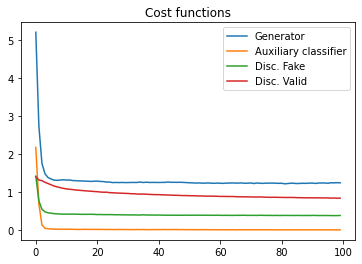

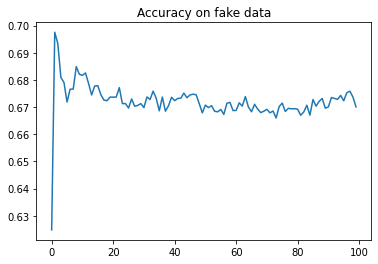

In [24]:
N_EPOCHS = 100

gen_optim = torch.optim.Adam(generator.parameters(), lr=0.00005, betas=(0.5, 0.999))
disc_optim = torch.optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999))
auxiliary_optim = torch.optim.Adam(auxiliary_classifier.parameters(), lr=0.00005, betas=(0.5, 0.999))

(
    gen_losses,
    aux_clf_losses,
    disc_fake_losses,
    disc_valid_losses,
    accuracies,
) = adversarial_train(
    generator,
    discriminator,
    auxiliary_classifier,
    gen_optim,
    disc_optim,
    auxiliary_optim,
    train_dataloader,
    cost_function,
    epochs=N_EPOCHS,
)

plt.plot(range(N_EPOCHS), gen_losses, label="Generator")
plt.plot(range(N_EPOCHS), aux_clf_losses, label="Auxiliary classifier")
plt.plot(range(N_EPOCHS), disc_fake_losses, label="Disc. Fake")
plt.plot(range(N_EPOCHS), disc_valid_losses, label="Disc. Valid")
plt.legend()
plt.title("Cost functions")
plt.show()

plt.plot(range(N_EPOCHS), accuracies)
plt.title("Accuracy on fake data")
plt.show()


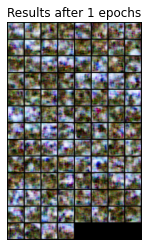

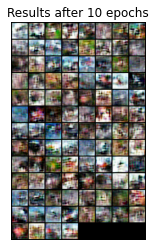

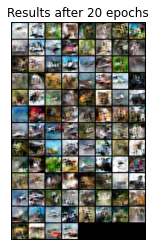

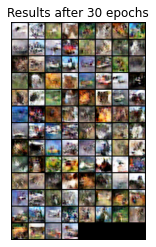

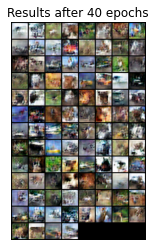

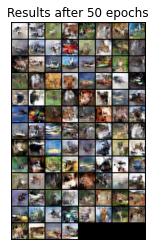

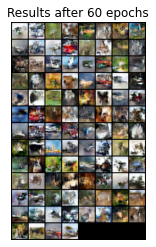

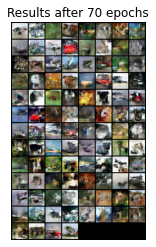

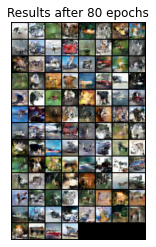

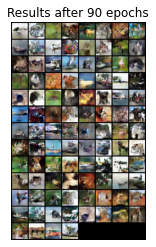

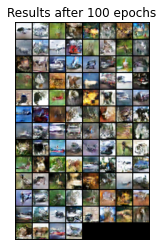

In [25]:
image = Image.open(f"sample_data/1.png")
plt.imshow(image)
plt.title(f"Results after 1 epochs")
plt.axis("off")
plt.show()

for i in range(10, N_EPOCHS + 1, 10):
    image = Image.open(f"sample_data/{i}.png")
    plt.imshow(image)
    plt.title(f"Results after {i} epochs")
    plt.axis("off")
    plt.show()